# Time Serie Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA 
from matplotlib import gridspec

%matplotlib inline

Let's see the obtained data

In [2]:
path_ = '../data/db_bsm_financial.csv'

In [3]:
data_ = pd.read_csv(path_)
data_['date'] = pd.to_datetime(data_['date'])
data_filt = data_[['ticker', 'date', 'close', 'volume']].sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

In [4]:
data_filt.head()

,ticker,date,close,volume
0,CNA.L,2004-01-01,208.714,0.0
1,CNA.L,2004-01-02,209.209,4410190.0
2,CNA.L,2004-01-05,209.703,9725302.0
3,CNA.L,2004-01-06,208.714,9867986.0
4,CNA.L,2004-01-07,207.230,14286636.0


In [5]:
print('The column close has %d rows with 0 value' %data_filt[data_filt['close'] == 0]['close'].shape[0])
print('The column volume has %d rows with 0 value' %data_filt[data_filt['close'] == 0]['volume'].shape[0])

The column close has 2 rows with 0 value
The column volume has 2 rows with 0 value


In order to play with this 0 values is going to change the value by an interpolation

In [6]:
data_filt = data_filt.replace(0, np.NaN)
for tick in data_filt['ticker'].unique():
    data_filt.loc[data_filt['ticker'] == tick, 'close'] = data_filt[data_filt['ticker'] == tick]['close'].interpolate()
    data_filt.loc[data_filt['ticker'] == tick, 'volume'] = data_filt[data_filt['ticker'] == tick]['volume'].interpolate()

In [7]:
def add_shifts(df_, col_id, col_calc_pl, new_col, shift):
    for id_ in df_[col_id].unique():
        df_by_id = df_[df_[col_id] == id_]
        df_.loc[df_[col_id] == id_, new_col] = df_by_id[col_calc_pl] - df_by_id[col_calc_pl].shift(shift)
        
    return df_

data_filt = add_shifts(data_filt, 'ticker', 'close', 'daily_pl', 1)
data_filt = add_shifts(data_filt, 'ticker', 'volume', 'vol_shift_1', 1)

This function return NaN values for the first date. So let's to ignore that

In [8]:
data_filt = data_filt.dropna()

In [9]:
data_filt.isna().sum()

ticker         0
date           0
close          0
volume         0
daily_pl       0
vol_shift_1    0
dtype: int64

## Daily_pl

First of all we are going to see a seasonal decompose between years 2017 and 2018 by a 22 days of frequency.

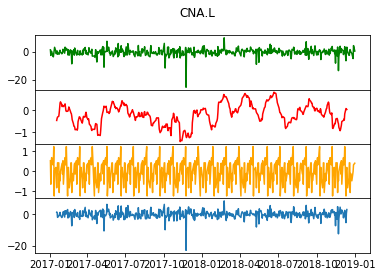

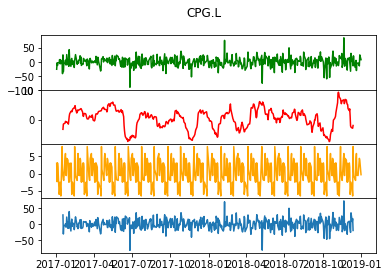

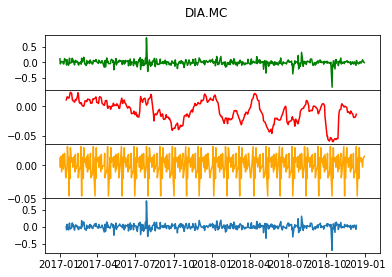

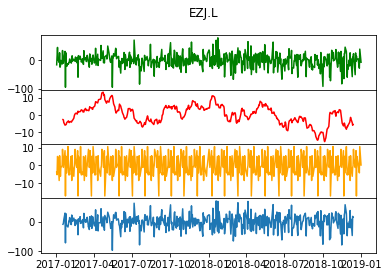

In [10]:
for tick in data_filt['ticker'].unique():
    df_ = data_filt[(data_filt['ticker'] == tick) & (data_filt['date'].dt.year >= 2017) & (data_filt['date'].dt.year <= 2018)]
    f, axarr = plt.subplots(4, sharex=True, sharey=False)
    f.suptitle(tick)
    axarr[0].plot(df_['date'], df_['daily_pl'], color='green')
    seas = seasonal_decompose(df_['daily_pl'].values, freq=22)
    axarr[1].plot(df_['date'], seas.trend, color='red')
    axarr[2].plot(df_['date'], seas.seasonal, color='orange')
    axarr[3].plot(df_['date'], seas.resid)
    f.subplots_adjust(hspace=0)
    for ax in axarr:
        ax.label_outer()

Only by these charts we can not say that the ts is stationary but it smells in that way. So let's do the Dickey-Fuller test.

In [11]:
test_df = {}
for tick in data_filt['ticker'].unique():
    test_df[tick] = adfuller(x=data_filt[(data_filt['ticker'] == tick) &
                                         (data_filt['date'].dt.year >= 2004)  &
                                         (data_filt['date'].dt.year <= 2018)]['daily_pl'])
    print('%s - p-value: %f' % (tick, test_df[tick][1]))

CNA.L - p-value: 0.000000
CPG.L - p-value: 0.000000
DIA.MC - p-value: 0.000000
EZJ.L - p-value: 0.000000


Because of the p-value is so small we can consider an stationary process. So the next step is to plot ACF and PACF to know which q and p use in an ARMA.

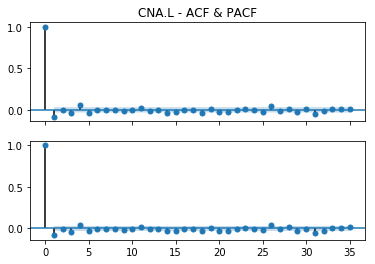

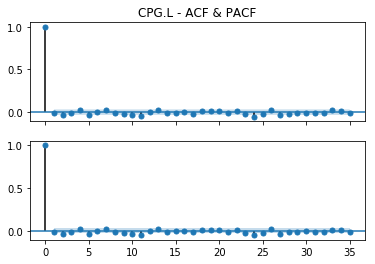

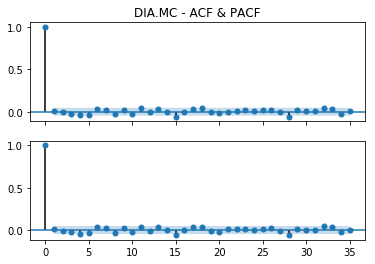

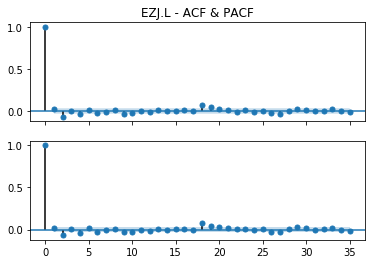

In [12]:
for tick in data_filt['ticker'].unique():
    df_ = data_filt[(data_filt['ticker'] == tick) & (data_filt['date'].dt.year >= 2004) & (data_filt['date'].dt.year <= 2018)]
    f, axarr = plt.subplots(2, sharex=True, sharey=False)

    plot_acf(df_['daily_pl'], ax=axarr[0], title='%s - ACF & PACF' % tick, lags=35)
    plot_pacf(df_['daily_pl'], ax=axarr[1], title='', lags=35)
    f.subplots_adjust()
    for ax in axarr:
        ax.label_outer()

In [13]:
for tick in data_filt['ticker'].unique():
    model = ARMA(data_filt[(data_filt['ticker'] == tick) &
                            (data_filt['date'].dt.year >= 2004) &
                            (data_filt['date'].dt.year <= 2018)]['daily_pl'].values,
                  order=(2,1)) 
    model_fit = model.fit() 
    output = model_fit.forecast(3) 
    print ('#' * 10 + ' %s ' % tick + '#' * 10)
    print('Forecast: %f / %f / %f' % tuple(output[0]))
    print('StdErr: %f / %f / %f' % tuple(output[1]))
    print('Interval1: %f / %f' % tuple(output[2][0]))
    print('Interval2: %f / %f' % tuple(output[2][1]))
    print('Interval3: %f / %f' % tuple(output[2][2]))
    print('\n')

########## CNA.L ##########
Forecast: 0.017036 / 0.045276 / 0.038878
StdErr: 3.972731 / 3.987514 / 3.987748
Interval1: -7.769374 / 7.803447
Interval2: -7.770108 / 7.860660
Interval3: -7.776964 / 7.854719


########## CPG.L ##########
Forecast: -0.574628 / -0.112933 / 0.270925
StdErr: 10.963702 / 10.964608 / 10.972097
Interval1: -22.063089 / 20.913832
Interval2: -21.603170 / 21.377305
Interval3: -21.233990 / 21.775840


########## DIA.MC ##########
Forecast: -0.003232 / -0.002422 / -0.002129
StdErr: 0.093046 / 0.093054 / 0.093075
Interval1: -0.185599 / 0.179135
Interval2: -0.184805 / 0.179961
Interval3: -0.184553 / 0.180295


########## EZJ.L ##########
Forecast: -3.927893 / 2.953441 / -1.218937
StdErr: 20.004837 / 20.011438 / 20.049383
Interval1: -43.136652 / 35.280866
Interval2: -36.268258 / 42.175139
Interval3: -40.515006 / 38.077131




Which we can set as a conclusion is that we can not choose the same p, q for different ts what is more not the same differencing make different ts stationary. 

## Vol_shift_1

Make the same study for other ts

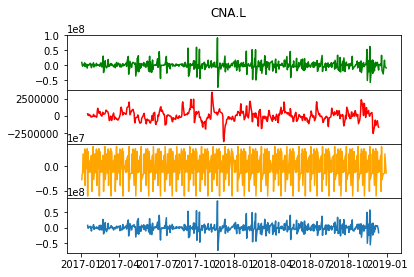

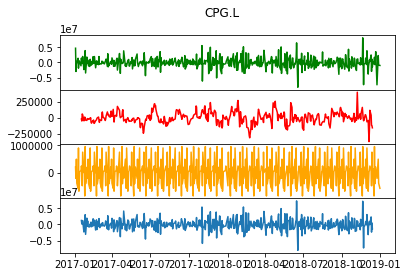

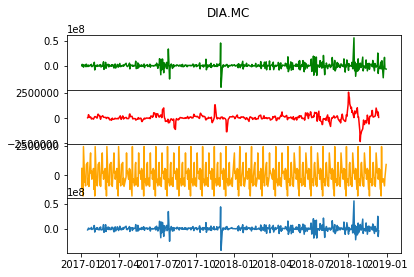

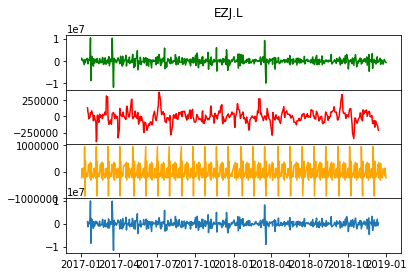

In [14]:
for tick in data_filt['ticker'].unique():
    df_ = data_filt[(data_filt['ticker'] == tick) & (data_filt['date'].dt.year >= 2017) & (data_filt['date'].dt.year <= 2018)]
    f, axarr = plt.subplots(4, sharex=True, sharey=False)
    f.suptitle(tick)
    axarr[0].plot(df_['date'], df_['vol_shift_1'], color='green')
    seas = seasonal_decompose(df_['vol_shift_1'].values, freq=20)
    axarr[1].plot(df_['date'], seas.trend, color='red')
    axarr[2].plot(df_['date'], seas.seasonal, color='orange')
    axarr[3].plot(df_['date'], seas.resid)
    f.subplots_adjust(hspace=0)
    for ax in axarr:
        ax.label_outer()

In [15]:
test_df = {}
for tick in data_filt['ticker'].unique():
    test_df[tick] = adfuller(x=data_filt[(data_filt['ticker'] == tick) &
                                         (data_filt['date'].dt.year >= 2004)  &
                                         (data_filt['date'].dt.year <= 2018)]['vol_shift_1'])
    print('%s - p-value: %f' % (tick, test_df[tick][1]))

CNA.L - p-value: 0.000000
CPG.L - p-value: 0.000000
DIA.MC - p-value: 0.000000
EZJ.L - p-value: 0.000000


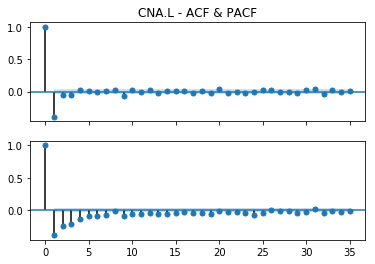

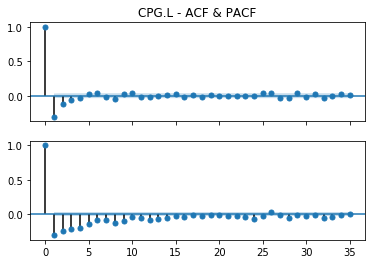

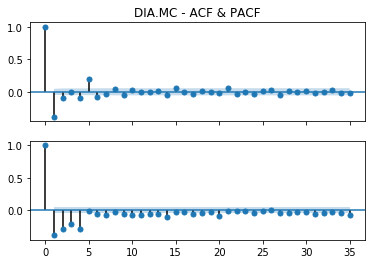

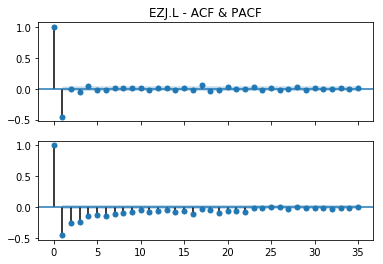

In [16]:
for tick in data_filt['ticker'].unique():
    df_ = data_filt[(data_filt['ticker'] == tick) & (data_filt['date'].dt.year >= 2004) & (data_filt['date'].dt.year <= 2018)]
    f, axarr = plt.subplots(2, sharex=True, sharey=False)

    plot_acf(df_['vol_shift_1'], ax=axarr[0], title='%s - ACF & PACF' % tick, lags=35)
    plot_pacf(df_['vol_shift_1'], ax=axarr[1], title='', lags=35)
    f.subplots_adjust()
    for ax in axarr:
        ax.label_outer()

In [17]:
for tick in data_filt['ticker'].unique():
    model = ARMA(data_filt[(data_filt['ticker'] == tick) &
                            (data_filt['date'].dt.year >= 2004) &
                            (data_filt['date'].dt.year <= 2018)]['vol_shift_1'].values,
                  order=(2,1)) 
    model_fit = model.fit() 
    output = model_fit.forecast(3) 
    print ('#' * 10 + ' %s ' % tick + '#' * 10)
    print('Forecast: %f / %f / %f' % tuple(output[0]))
    print('StdErr: %f / %f / %f' % tuple(output[1]))
    print('Interval1: %f / %f' % tuple(output[2][0]))
    print('Interval2: %f / %f' % tuple(output[2][1]))
    print('Interval3: %f / %f' % tuple(output[2][2]))
    print('\n')

########## CNA.L ##########
Forecast: 14648662.871928 / 3801498.034894 / 3024923.418930
StdErr: 9812417.542539 / 11676767.579148 / 11717878.126391
Interval1: -4583322.112717 / 33880647.856573
Interval2: -19084545.876081 / 26687541.945868
Interval3: -19941695.684026 / 25991542.521887


########## CPG.L ##########
Forecast: 1821890.850705 / 702221.027472 / 258843.856752
StdErr: 5851078.685479 / 6783320.478432 / 6915215.961138
Interval1: -9646012.643543 / 13289794.344954
Interval2: -12592842.805848 / 13997284.860791
Interval3: -13294730.372395 / 13812418.085899


########## DIA.MC ##########
Forecast: 4007827.764641 / 696120.022616 / 516507.839881
StdErr: 5152816.172066 / 6183963.697188 / 6218928.513366
Interval1: -6091506.351564 / 14107161.880847
Interval2: -11424226.105576 / 12816466.150807
Interval3: -11672368.068745 / 12705383.748508


########## EZJ.L ##########
Forecast: 1824220.173247 / 265779.190735 / 215269.357114
StdErr: 3452579.174091 / 4394652.608948 / 4398438.573234
Interval1